In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import datetime as dt

# Modèle boite noire 02


L'idée est d'estimer les paramètres du modèle à partir de la mesure expérimentale de la température intérieure ($T$) et des données météo. On n'obtient pas forcement une valeur physique significative pour ces coefficients, mais cela permet d'estimer et de comparer les variations de jour en jour, et donc à priori de voir l'effet du comportement de l'habitant (ouverture des fenêtres et rideaux  en été). 

# Le modèle 'boite-noire'

On souhaite le modèle le plus simple possible, avec seulement deux coefficients : la résistance thermique $h$ avec l'extérieure, une masse thermique $M$ et un flux de chaleur externe $\eta\Phi(t)$.

Schéma électrique équivalent :
![schéma eq.](images/sch_blackbox02.png)

et l'équation différentielle corespondante:
$$
 \frac{dT}{dt} = \frac{h}{M} \,\left[ T_{ext}(t) - T \right] + \frac{\eta}{M} \, \Phi(t)
$$

$T(t)$ est la température à l'intérieure de l'appartement.  
$T_{ext}(t)$ est la température extérieure donnée par la météo.  
$\Phi(t)$ est le flux solaire (en Watt) sur les surfaces vitrées. 

Il y a deux paramètres inconnues, tous les deux normés par la masse thermique $M$:  
 * $\eta$ qui correspond à l'absorption des rayons solaire, normalement entre 0 et 1.
 * $h$ qui correspond à l'isolation avec l'air extérieur (en W/K).
 
 
 
 * $M$, enfin, est la masse thermique de l'appartement (en J/K) ... Elle détermine le temps de réponse caractérique du système, et est pour cette raison difficile à estimer parce que non unique. 
 
 

### Chargement des données

Données obtenues avec le notebook [get_data_and_preprocess.ipynb](./get_data_and_preprocess.ipynb).

In [6]:
df_full  = pd.read_pickle( 'weatherdata.pck' )

In [7]:
df = df_full[['T_int', 'temperature', 'flux_tot', 'windSpeed']].copy()

On a l'enregistrement de la température intérieure ($T_{int}$) et la température extérieure ('temperature') :

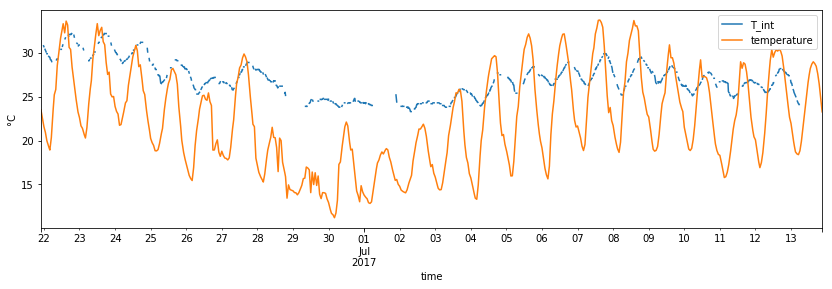

In [8]:
df[['T_int', 'temperature']].plot( figsize=(14, 4) ); plt.ylabel('°C');

Et le flux solaire, calculé pour mon appartement, et projété suivant la surface et l'orientation de mes fenètres (Velux): 

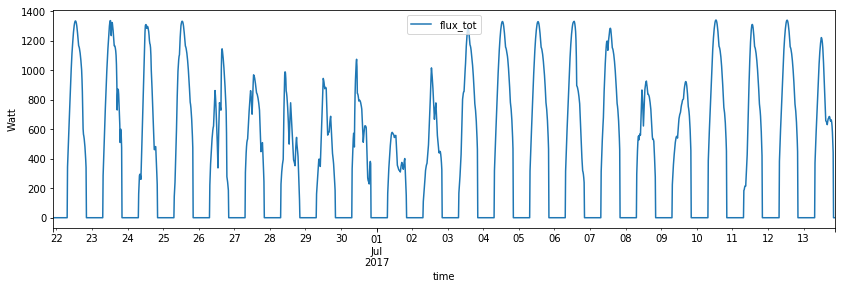

In [9]:
# Flux solaire sur les vitres:
df[['flux_tot']].plot( figsize=(14, 4) ); plt.ylabel('Watt');

### Solveur équation diff. (ODE)

L'équation est résolue en temps avec `odeint` de scipy ([doc](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.integrate.odeint.html), [OdePack](http://people.sc.fsu.edu/~jburkardt/f77_src/odepack/odepack.html)).

In [10]:
from scipy.integrate import odeint

In [11]:
def get_dTdt(  T, t, params, get_Text, get_Phi ):
    """ dérivé de la température p/r au temps
        params :   [ h/M  ,  eta/M ]
        get_Text, get_Phi: fonctions d'interpolation 
    """
    
    T_ext  = get_Text( t )
    phi = get_Phi( t ) 
    
    dTdt = params[0] * ( T_ext - T ) + params[1] / 100 * phi
    
    return 1e-6*dTdt


def apply_model( data, T_start, params, full_output=False ):

    data_dict = data.to_dict(orient='list')
    time_sec = data.index.astype(np.int64) // 10e9    # conversion en secondes

    # construction des fonctions d'interpolations: 
    get_Text = lambda t: np.interp( t, time_sec, data_dict['temperature'] )
    get_Phi  = lambda t: np.interp( t, time_sec, data_dict['flux_tot'] )

    T_theo = odeint(get_dTdt, T_start, time_sec, args=(params, get_Text, get_Phi  ), \
                full_output=full_output, h0=30*60)
    # h0 : pas de temps initial utilisé par le solveur
    
    return T_theo.flatten()

**Rq:** Facteur _100_ et _1e-6_ pour avoir des valeurs proches de l'unité, et le même ordre de grandeur entre $\Phi$ et $\Delta T$... pour l'optimisation 

### Test sur les données entières :

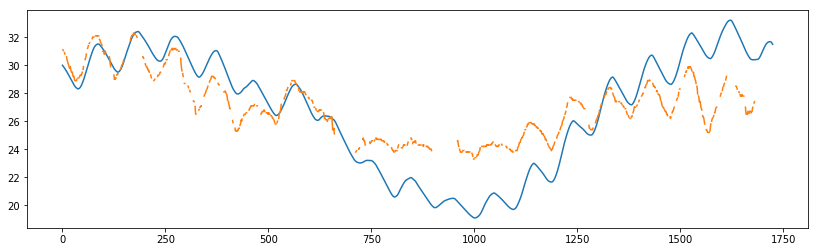

In [39]:
params =  ( 65, 70 )

res = apply_model( df, 30, params )

plt.figure( figsize=(14, 4) )
plt.plot( res )
plt.plot( df['T_int'].as_matrix() ) ;

# Estimation jour par jour

Les paramètres $\eta$ et $h$ ne sont en réalité pas constant. Ils dépendante de l'usage de l'appartement, principalement de l'ouverture des fenêtres et à la position des volets sur celle-ci. Ils sont donc fonctions de la période de la journée, et de la météo. L'idée est d'estimer leurs valeurs jour par jour. 

mais :
* la nuit, $\Phi = 0$ donc $\eta$ est non déterminé
* le jour, $T_{ext}(t)$ est fortement corrélé avec $\Phi(t)$. Découpler les deux paramètres n'est alors pas évident. 

Les estimations sont donc effectuées séparement : le jour pour $\eta$ (avec un $h_{min}$ résiduel), et la nuit pour $h$ (correspondant à la ventilation).

In [12]:
def get_errorfit( params, data, T_start    ):
    """ Calcul le modele pour les données et les paramètres
        puis calcul l'erreur avec les données expérimentals (non NaN)
    """
    
    T_exp = data['T_int'].as_matrix()
    T_theo = apply_model( data, T_start, params )
    
    delta = (T_exp - T_theo)**2
    return np.sum( delta[  ~np.isnan( delta ) ] )
  

In [13]:
"""  on distingue le fit suivant la nuit ou le jour
        pour ne fiter qu'un seul paramètre
"""
from scipy.optimize import fminbound


def fit_model_p1( data, T_start, param_0  ):
    func0 = lambda x: get_errorfit( (param_0, x), data, T_start  )
    x1, x2 = (.1, 1000)
    param_1 = fminbound(func0, x1, x2, disp=0)
    #param_1 = fmin(func0, 20)

    return param_1

def fit_model_p0( data, T_start, param_1 ):
    func1 = lambda x: get_errorfit( (x, param_1), data, T_start  )
    x1, x2 = (.1, 1000)
    param_0 = fminbound(func1, x1, x2, disp=0)
    #param_0 = fmin(func1, 20)
    
    return param_0

### Découpage en période jour / nuit

In [14]:
""" Estimation des périodes de jour et de nuit à partir du flux solaire
"""

df['isnight'] = ( df['flux_tot'] == 0 ).astype(int)

# Permet de numéroter les périodes :
nights_days = df['isnight'].diff().abs().cumsum()
nights_days[0] = 0

df_byday  = df.groupby(nights_days) 

Groupes = [ int( k ) for k in df_byday.groups.keys() ]

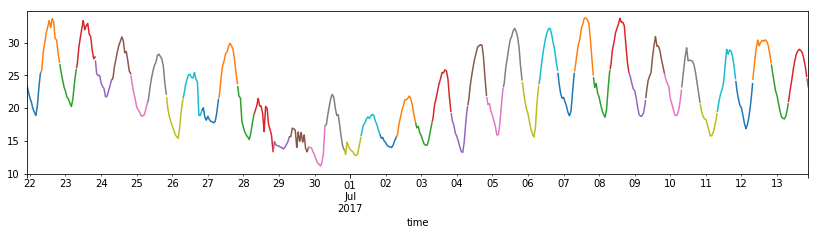

In [15]:
df_byday['temperature'].plot( figsize=(14, 3) );

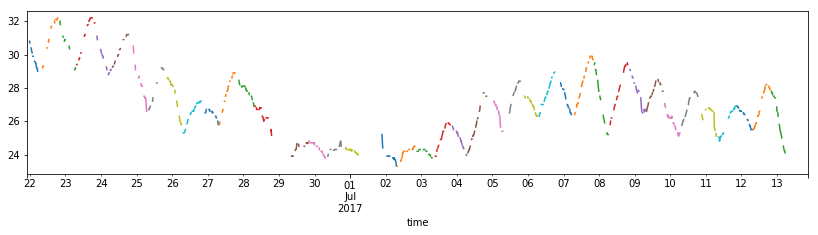

In [16]:
df_byday['T_int'].plot( figsize=(14, 3) );

### Ajustement période par période

In [17]:
def fit_a_day( data, T_zero ):
    """ Estime le modèle sur les données  'data'
        avec la température initial 'T_zero'
    """

    # Gestion des données exp. manquante :
    T_exp = data['T_int'].as_matrix()
    nombre_nonNaN = T_exp.size - np.isnan( T_exp ).sum()
    if nombre_nonNaN < 10:
        # pas assez de donnée pour faire le fit
        h, eta = np.nan, np.nan
        res = np.full( T_exp.shape , np.nan)
        
    else:
        eta_night = 0
        h_day = 20   # valeur résiduel ... arbitraire pour le moment

        if  data['isnight'].all():
            # nuit
            h = fit_model_p0( data, T_zero, eta_night )
            eta = eta_night
        else:
            # jour
            h = h_day
            eta = fit_model_p1( data, T_zero, h_day )

        # Calcul le modèle avec les paramètres optenus:
        res = apply_model( data, T_zero, (h, eta) )
    
    return (h, eta), res

### Tracé pour une période (debug) 

In [18]:
len( Groupes )

45

2017-07-09 07:30:00
(20, 73.111003126425089)


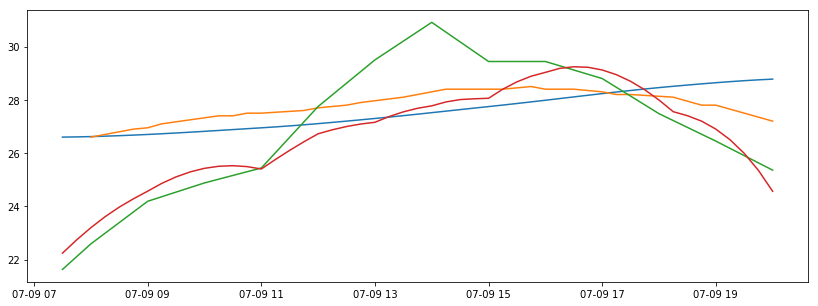

In [19]:
data = df_byday.get_group(  Groupes[35] )

T_int = data['T_int'].interpolate().as_matrix()
T_zero = T_int[ ~ np.isnan( T_int ) ][0]

params, res = fit_a_day( data, T_zero )

print( data.index[0] )
print( params )

plt.figure( figsize=(14, 5) )
plt.plot(data.index,  res )
plt.plot(data.index, T_int );
plt.plot(data.index, data['temperature'].as_matrix() );

plt.plot(data.index, data['flux_tot'].as_matrix()/100 + 20 );

### Calcul pour toutes les périodes :

prends du temps

In [20]:
# init
df['T_theo'] = 0
df['eta_M'], df['h_M'] = 0, 0

# valeur initiale
T_zero = df['T_int'][ df['T_int'].first_valid_index() ]

for grp_id in Groupes:
    print( '%i, ' % grp_id, end='' )
    data_day = df_byday.get_group(  grp_id ) 
    
    # debug cas où aucun donnée exp. :
    if np.isnan( T_zero ):
        T_int = data_day['T_int']
        if np.isnan(  T_int ).all():
            T_zero = 0
        else:
            T_zero = data_day['T_int'][ data_day['T_int'].first_valid_index() ]
    
    # estimation
    params, res = fit_a_day( data_day, T_zero )
    
    # save
    df.loc[ data_day.index, 'T_theo'] =  res
    df.loc[ data_day.index, 'eta_M'] =  params[1]
    df.loc[ data_day.index, 'h_M'] =  params[0]

    # valeur initiale pour l'étape suivante
    T_zero = res[-1]

    
print('done')

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, done


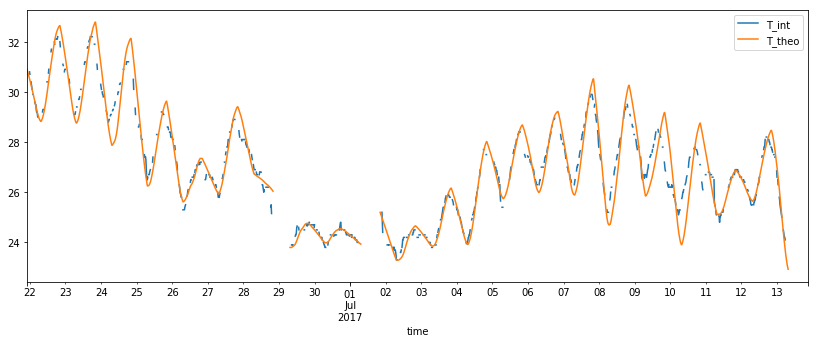

In [21]:
df[['T_int', 'T_theo']].plot( figsize=(14, 5)  ); 

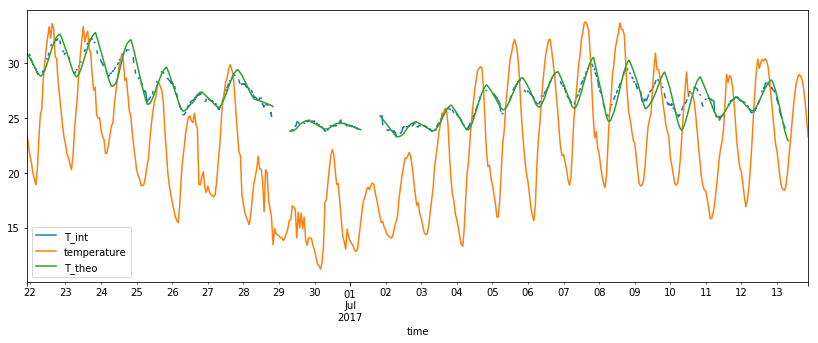

In [22]:
df[['T_int', 'temperature', 'T_theo']].plot( figsize=(14, 5)  ); 

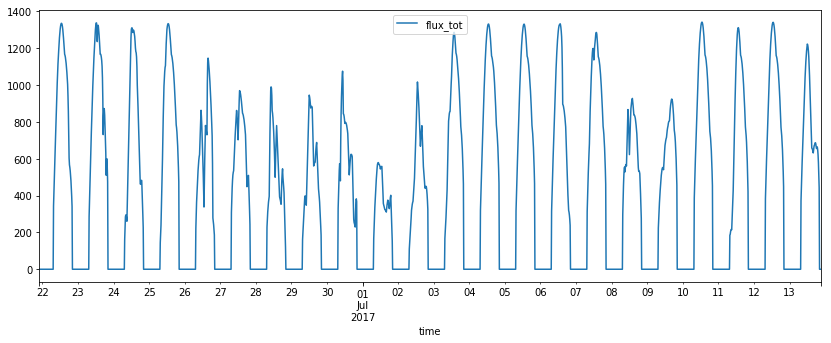

In [23]:
df[['flux_tot']].plot( figsize=(14, 5)  ); 

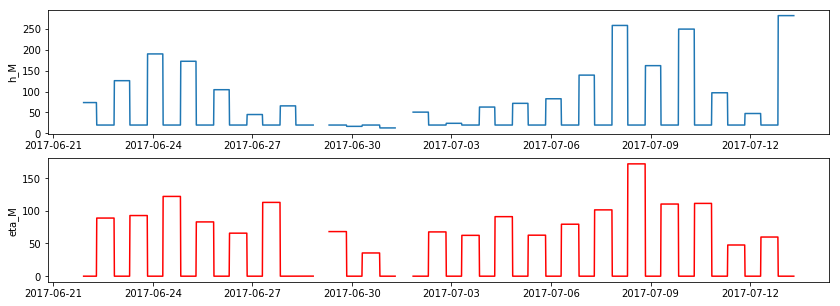

In [24]:
plt.figure( figsize=(14, 5) )
plt.subplot( 2, 1, 1 )
plt.plot( df[['h_M']] ); plt.ylabel('h_M');

plt.subplot( 2, 1, 2 )
plt.plot( df[['eta_M']], 'r' ); plt.ylabel('eta_M');

# Ordres de grandeur

**eta :** c'est un pourcentage entre 0 et 100  


** h :** Il y a deux contibutions: 
    - h_min : L'isolation globale du batiment (mur, toit et surtout fenêtres). Cette valeur doit être constante.
    - h_aero : Les infiltrations d'air et aérations. 



** M : ** La masse thermique  
M ~  0.1e6 J/K    ???

- h_min correspond à l'isolation maximal de l'appart, toutes fenêtres fermés 
- h_max, à la ventillation maximal, toutes fenêtres ouvertes (+ vent ?)
  
  
- eta_min correspond à tous les volets fermés
- eta_max sans volet

### Estimation de h_min


    h_min = aire_vitre * U_vitrage + perimetre * U_cadres + aire_parois * h_parois 

In [196]:
U_vitrage = 2.8 # W/m2/K, typiquement pour du double vitrage
U_cadres =  0.15 + 0.016  # W/m/K,  pour un cadre en bois de section carré, c'est en fait la conductivité du bois
                          # + psi ... 
    
aire_vitre = 0.6*0.8*2 + 1.2*0.8 + 0.3*0.72*4 + 0.25**2 # m2 
perimetre = (0.6+0.8)*4 + (1.2+0.8)*2 + 2*(0.3+0.72)*4 + 4*0.25

aire_parois = 4.59*7.94*2 # m2
h_parois =  0.04 / 0.15 # W/m2/K - pour de la laine de roche

In [197]:
h_min = aire_vitre * U_vitrage + perimetre * U_cadres + aire_parois * h_parois
print('h_min : %f  W/K' % h_min)

h_min : 30.521480  W/K


### Résidus

In [144]:
R = df['T_int'] - df['T_theo']

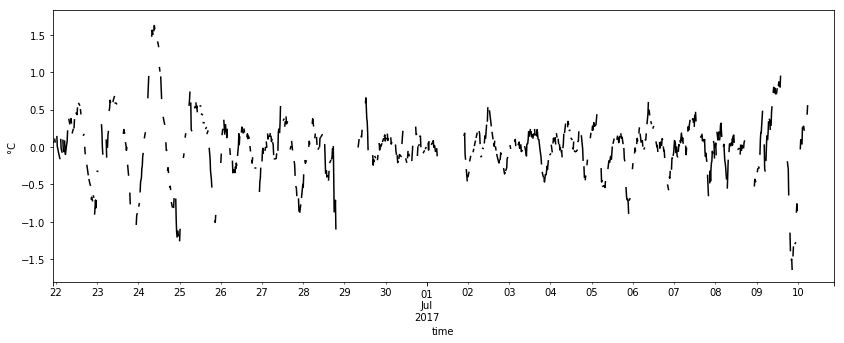

In [145]:
R.plot( figsize=(14, 5), style='k'  ); plt.ylabel('°C'); 

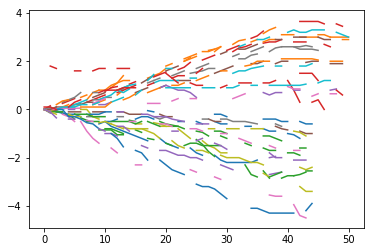

In [146]:
# Plot variation relative temp. 

plt.figure( );
for grp_id in Groupes:
    data = df_byday.get_group(  grp_id )
    
    if np.isnan( data['T_int'] ).all():
        continue
        
    T_int = data['T_int'].as_matrix()
    Tmin, Tmax = T_int[ ~ np.isnan( T_int ) ].min(), T_int[ ~ np.isnan( T_int ) ].max()
    if  data['isnight'].all():
        T_int = T_int - Tmax
    else:
        T_int = T_int - Tmin
    plt.plot( T_int )

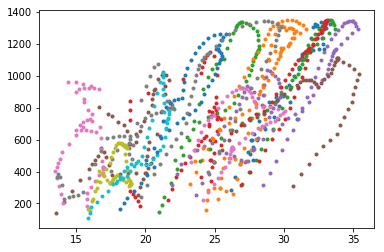

In [147]:
# Corrélation T_ext <-> Phi
from scipy.stats import pearsonr
norm = lambda X: (X - X.min())/(X.max() - X.min())

coeffs_cor, groupes_id = [], []

plt.figure( );
for grp_id in Groupes[2:]:
    data = df_byday.get_group(  grp_id )
        
    if data['isnight'].all():
        continue
        
    T_ext = data['temperature'].as_matrix()
    phi = data['flux_tot'].as_matrix()
    
    #T_ext, phi = norm(T_ext), norm(phi)
    
    plt.plot( T_ext, phi, '.' )
    
    coeffs_cor.append( pearsonr(T_ext, phi)[0] )
    groupes_id.append( grp_id )
#plt.axis('equal')

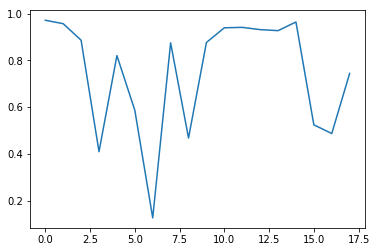

In [148]:
plt.plot( coeffs_cor ) ;

In [149]:
sorted( zip( groupes_id, coeffs_cor ), key=lambda x:x[1] )

[(15, 0.1257921632515876),
 (9, 0.40917011085242239),
 (19, 0.46763496201737009),
 (35, 0.48677745179864396),
 (33, 0.52412913237376102),
 (13, 0.5865258502699624),
 (37, 0.74396875291956688),
 (11, 0.82021811344320861),
 (17, 0.87488831768325903),
 (21, 0.8763284486020505),
 (7, 0.88604083778005482),
 (29, 0.92692936575363694),
 (27, 0.93133685074413786),
 (23, 0.93915891237467986),
 (25, 0.9409801460586068),
 (5, 0.95668460681889333),
 (31, 0.96401303713573283),
 (3, 0.97146110192154611)]

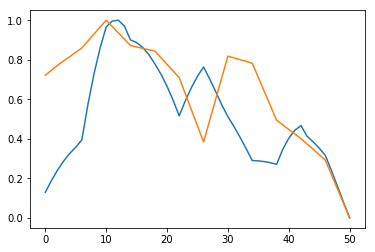

In [154]:
data = df_byday.get_group(  Groupes[13] )

T_int = data['T_int'].as_matrix()
T_ext = data['temperature'].as_matrix()
phi = data['flux_tot'].as_matrix()

plt.plot( norm(phi) )
plt.plot( norm(T_ext) );